In [15]:
# Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping




In [16]:

sns.set_style('darkgrid')

In [ ]:
import os
# import zipfile
import pandas as pd

# # Make sure these point to actual ZIP files
# train_zip = 'data2/train.zip'  
# test_zip = 'data2/test.zip'  

extract_path = "data2"  # Where to extract files

# # Extract train.zip
# if os.path.exists(train_zip):  # Check if the zip file exists
#     with zipfile.ZipFile(train_zip, 'r') as zipp:
#         zipp.extractall(extract_path)
# else:
#     print(f"Error: {train_zip} not found!")

# # Extract test.zip
# if os.path.exists(test_zip):  # Check if the zip file exists
#     with zipfile.ZipFile(test_zip, 'r') as zipp:
#         zipp.extractall(extract_path)
# else:
#     print(f"Error: {test_zip} not found!")

# # Set correct paths after extraction
train_dir = os.path.join(extract_path, "train")  
test_dir = os.path.join(extract_path, "test")

# # Check if extraction worked
# if not os.path.exists(train_dir):
#     print(f"Error: Extracted folder {train_dir} not found!")

# if not os.path.exists(test_dir):
#     print(f"Error: Extracted folder {test_dir} not found!")

# Get file names and labels
filenames = os.listdir(train_dir)
labels = [x.split(".")[0] for x in filenames]  # Adjust if your filenames are different

# Create DataFrame
df = pd.DataFrame({
    "filepaths": [os.path.join(train_dir, f) for f in filenames],  
    "labels": labels
})

print(df.head())  # Display the first few rows
print(train_dir)



TypeError: join() argument must be str, bytes, or os.PathLike object, not 'list'

In [5]:
# train_dir = 'data\\train'

# filepaths = []
# labels = []

# folds = os.listdir(train_dir)

# for fold in folds:
#     foldpath = os.path.join(train_dir, fold)
    
#     files = os.listdir(foldpath)
#     for f in files:
#         fpath = os.path.join(foldpath, f)
        
#         filepaths.append(fpath)
#         labels.append(fold)
        
# df = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})


# test_dir = 'data\\test'

# filepaths = []
# labels = []

# folds = os.listdir(test_dir)

# for fold in folds:
#     foldpath = os.path.join(test_dir, fold)
    
#     files = os.listdir(foldpath)
#     for f in files:
#         fpath = os.path.join(foldpath, f)
        
#         filepaths.append(fpath)
#         labels.append(fold)
        
# df_test = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})

# test_dir = 'data\\test2'

# filepaths = []
# labels = []

# folds = os.listdir(test_dir)
# for fold in folds:
#     foldpath = os.path.join(test_dir, fold)
    
#     files = os.listdir(foldpath)
#     for f in files:
#         fpath = os.path.join(foldpath, f)
        
#         filepaths.append(fpath)
#         labels.append(fold)
        
# df_test2 = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})


In [6]:
# plt.figure(figsize=(20,20)) # specifying the overall grid size
# plt.subplots_adjust(hspace=0.4)

# j=0
# for _,row in df.iterrows():
#     j += 1
#     plt.subplot(1,10,j)    # the number of images in the grid is 10*10 (100)
#     image = imread(row["filepaths"])
#     plt.imshow(image)
#     plt.title(row["labels"],fontsize=12)
#     plt.axis('off')
#     if j>9:
#         break
# plt.show()

# plt.figure(figsize=(20,20)) # specifying the overall grid size
# plt.subplots_adjust(hspace=0.4)

In [8]:


# train test split using dataframe

labels = df['labels']
X_train, X_val = train_test_split(df, test_size=0.2, stratify=labels, random_state = 42)
print('The shape of train data',X_train.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (20000, 2)
The shape of validation data (5000, 2)


In [ ]:
labels = ['cat','dog']

label1,count1 = np.unique(X_train.labels,return_counts=True)
label2,count2 = np.unique(X_val.labels,return_counts=True)

print("train", label1, count1)
print("val", label2, count2)


train ['cat' 'dog'] [10000 10000]
val ['cat' 'dog'] [2500 2500]


Dataprep

In [10]:
# parameters
image_size = 128 # image size 128x128
image_channel = 3 # color channels
bat_size = 15 # batchsize

In [12]:


train_datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True)
train_generator = train_datagen.flow_from_dataframe(X_train,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=(image_size, image_size),
                                       color_mode='rgb',
                                       class_mode='categorical' ,
                                       batch_size=bat_size)


test_datagen =  ImageDataGenerator(rescale=1./255,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True)
# test_gen = test_datagen.flow_from_dataframe(X_test,
#                                        x_col='filepaths',
#                                        y_col='labels',
#                                        target_size=(image_size, image_size),
#                                        color_mode='rgb',
#                                        class_mode='categorical',
#                                        batch_size=32)

val_datagen =  ImageDataGenerator(rescale=1./255,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True)

val_generator = val_datagen.flow_from_dataframe(X_val,
                                      x_col='filepaths',
                                      y_col='labels',
                                       target_size=(image_size, image_size),
                                      color_mode='rgb',
                                      class_mode='categorical',
                                      batch_size=32)

# custom_generator = val_datagen.flow_from_dataframe(df_test2,
#                                       x_col='filepaths',
#                                       y_col='labels',
#                                        target_size=(image_size, image_size),
#                                       color_mode='rgb',
#                                       class_mode='categorical',
#                                       batch_size=32)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 20000 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 5000 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [ ]:

from tensorflow import keras
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# base_model = keras.applications.InceptionResNetV2(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(image_size, image_size, image_channel),
#     pooling=max,
#     classes=1000,
#     classifier_activation="softmax"
# )

In [ ]:

# from tensorflow.keras.optimizers import Adamax

# model = Sequential([
#     base_model,
#     Flatten(),
    
    
#     Dense(256,activation='relu'),
#     Dense(128,activation='relu'),
#     Dense(64,activation='relu'),
#     Dense(32,activation='relu'),
#     Dense(2,activation='softmax'),
# ])

# model.compile(optimizer=Adamax(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
# learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',
#                                             patience=3,
#                                             factor=0.1
#                                             )

# early_stoping = EarlyStopping(monitor='val_loss',patience= 4,restore_best_weights=True,verbose=0)



In [ ]:
# model.summary()

In [ ]:
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=30,
#     batch_size=bat_size,
#     callbacks=[early_stoping, learning_rate_reduction]  # Add callbacks here
# )

In [ ]:
image_size

128

In [ ]:
model = Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')  # Binary classification (cats vs dogs)
])
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [ ]:
CALLBACKS = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=2, verbose=1, mode='auto')
]



# early_stoping = EarlyStopping(monitor='val_loss',patience= 4,restore_best_weights=True,verbose=0)


In [ ]:
total_train = df.shape[0]
total_train

557

In [ ]:



total_validate = df_test.shape[0]


history = model.fit(train_generator, 
                    epochs=35, 
                    validation_data=val_generator,
                    batch_size=bat_size,
                    callbacks=CALLBACKS,
                    steps_per_epoch=total_train//bat_size
                    )

Epoch 1/35
37/37 [==============================] - 9s 232ms/step - loss: 2.7557 - accuracy: 0.5978 - val_loss: 1.9758 - val_accuracy: 0.5571 - lr: 1.0000e-10
Epoch 2/35
37/37 [==============================] - 8s 227ms/step - loss: 2.4321 - accuracy: 0.6273 - val_loss: 2.7539 - val_accuracy: 0.5643 - lr: 1.0000e-10
Epoch 3/35
36/37 [============================>.] - ETA: 0s - loss: 2.4073 - accuracy: 0.6056
Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-10.
37/37 [==============================] - 8s 222ms/step - loss: 2.3999 - accuracy: 0.6052 - val_loss: 2.2616 - val_accuracy: 0.5643 - lr: 1.0000e-10
Epoch 4/35
37/37 [==============================] - 8s 222ms/step - loss: 2.6867 - accuracy: 0.5996 - val_loss: 2.2906 - val_accuracy: 0.5286 - lr: 1.0000e-10
Epoch 5/35
37/37 [==============================] - 8s 224ms/step - loss: 2.7712 - accuracy: 0.5867 - val_loss: 2.6369 - val_accuracy: 0.4857 - lr: 1.0000e-10
Epoch 6/35
37/37 [==============================] - 9s 231ms/s

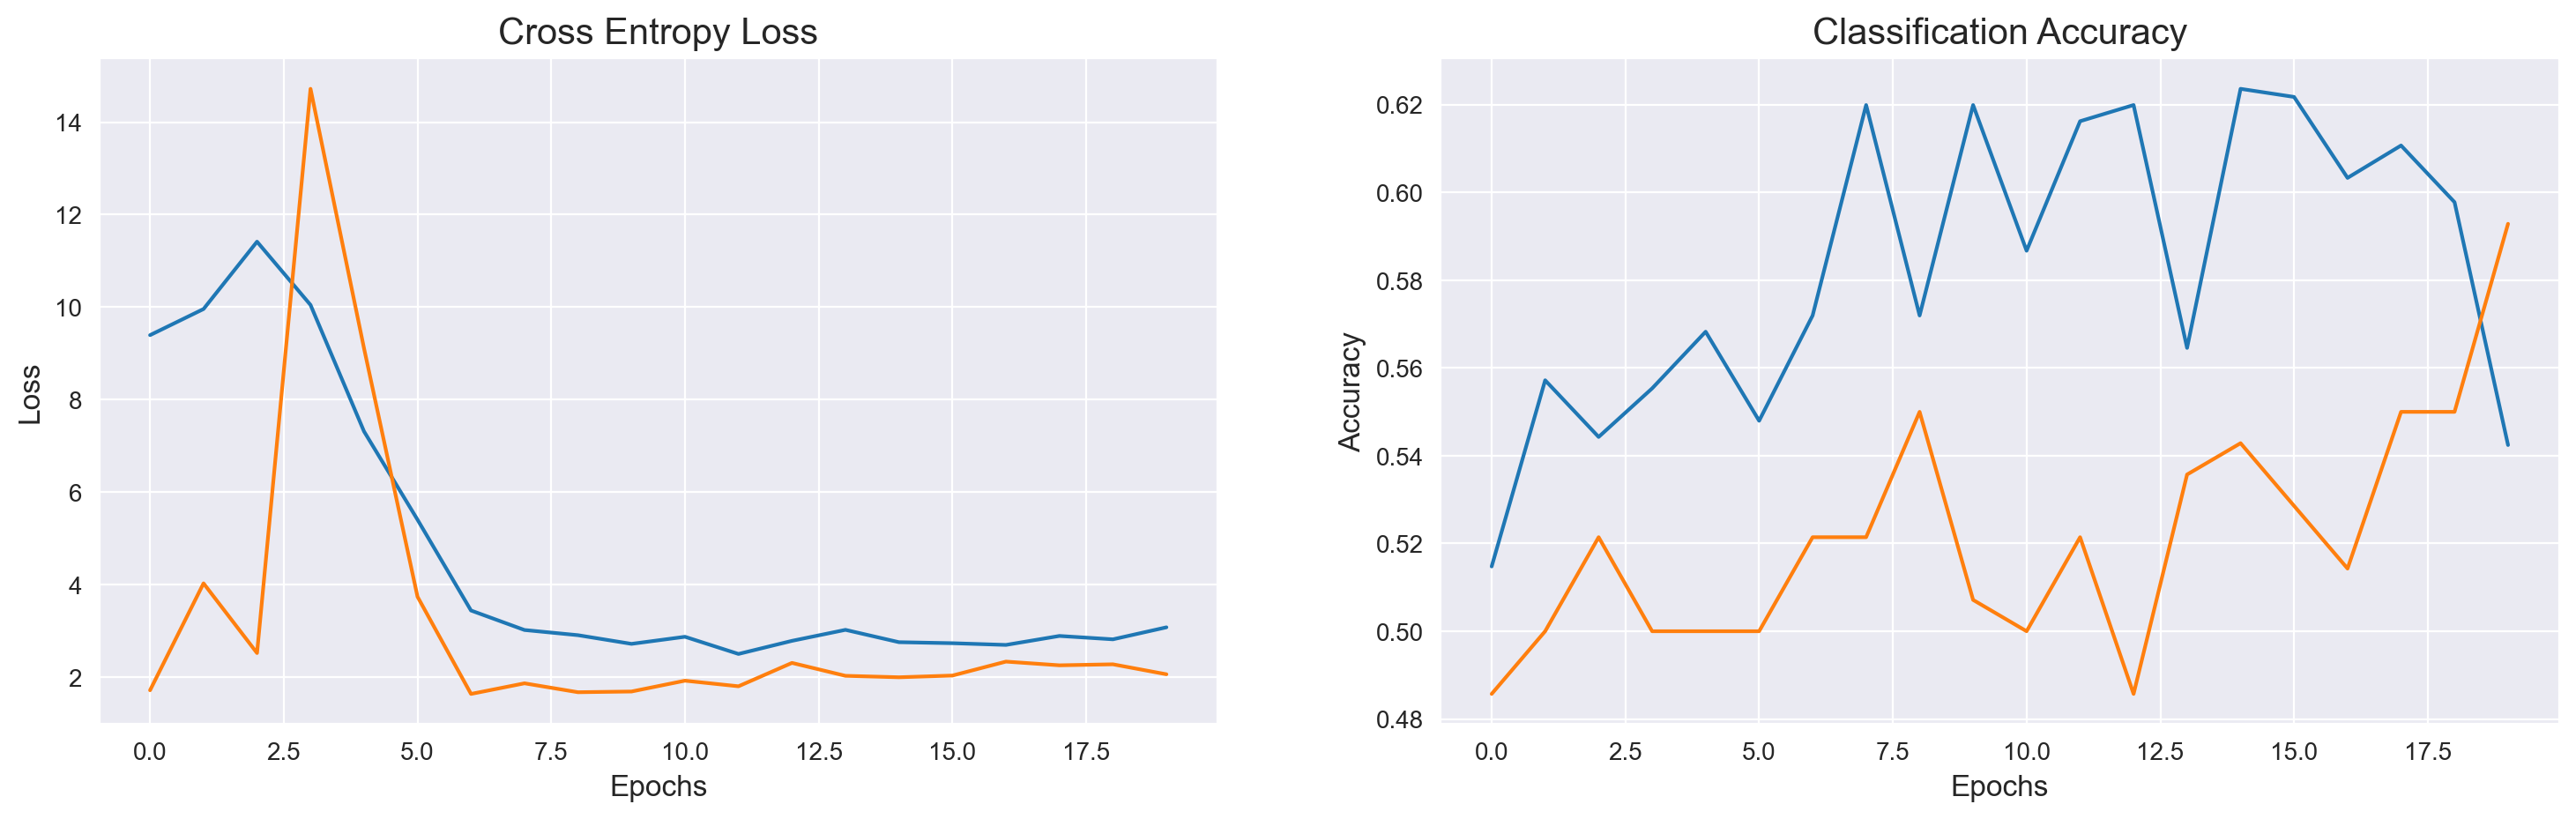

In [ ]:


# plots for accuracy and Loss with epochs

error = pd.DataFrame(history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()



In [ ]:
preds = model.predict(custom_generator)
y_pred = np.argmax(preds, axis=1)  # Convert probabilities to class labels
print(preds)

1/1 [==============================] - 0s 233ms/step
[[0.30699342 0.69300663]
 [0.01647362 0.9835264 ]]


38/38 [==============================] - 4s 102ms/step


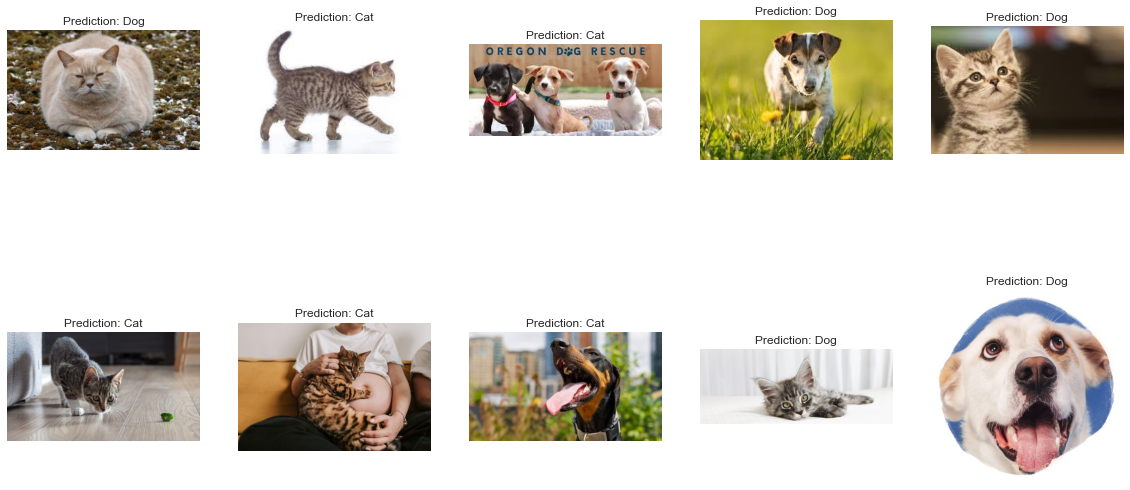

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = {0: "Cat", 1: "Dog"}

# Get predictions
preds = model.predict(train_generator)
y_pred = np.argmax(preds, axis=1)  # Convert probabilities to class labels

# Get the correct filenames in the order used by the generator
ordered_filenames = [train_generator.filenames[i] for i in train_generator.index_array]

# Plot images with predictions (limit to 10 images)
num_images = min(len(ordered_filenames), 10)

plt.figure(figsize=(20, 10))
for i in range(num_images):
    img_path = ordered_filenames[i]  # Correctly ordered image path
    img = plt.imread(img_path)  # Read image

    plt.subplot(2, 5, i + 1)  # Create subplot (2 rows, 5 columns)
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[y_pred[i]]}", fontsize=12)  # Show class name
    plt.axis("off")

plt.show()


In [ ]:
test_score = model.evaluate(test_gen)

1/1 [==============================] - 0s 154ms/step - loss: 2.5475 - accuracy: 0.5000


1/1 [==============================] - 0s 152ms/step


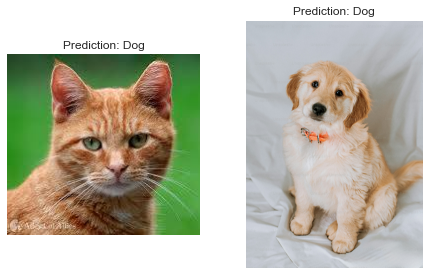

In [ ]:
# Define class names
class_names = {0: "Cat", 1: "Dog"}

# Get predictions
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)  # Convert probabilities to class labels

# Get the filenames from the generator
filenames = test_gen.filenames  # List of image file paths
num_images = min(len(filenames), 10)  # Limit to 10 images for display

# Plot images with predictions
plt.figure(figsize=(20, 10))
for i in range(num_images):
    img_path = filenames[i]  # Get image path
    img = plt.imread(img_path)  # Read image

    plt.subplot(2, 5, i + 1)  # Create subplot (2 rows, 5 columns)
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[y_pred[i]]}", fontsize=12)  # Show class name
    plt.axis("off")

plt.show()

38/38 [==============================] - 4s 105ms/step


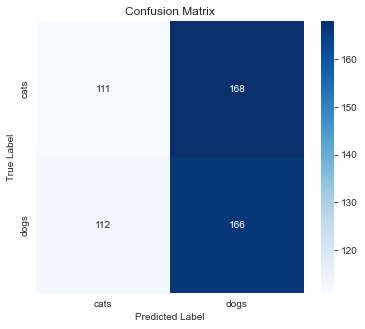

In [ ]:
# Get true labels from the test generator
y_true = train_generator.classes  # Correct way to access true labels

# Get predicted labels
preds = model.predict(train_generator)
y_pred = np.argmax(preds, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels from the generator
class_names = list(train_generator.class_indices.keys())  # Extract class names

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()